## 1. Prepare Python environment

In [2]:
# Install custom Python packages
!pip3 install pyeucountrycodes --quiet
!pip3 install calplot --quiet
!pip3 install gradio --quiet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
# Load required Python packages
import os, re, requests, logging, calplot
import pandas as pd
import dask.dataframe as dd
import multiprocessing as mp
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar
ProgressBar().register()
from tqdm import tqdm
from itertools import product
from eu_country_codes import COUNTRY_CODES
import gradio as gr
import plotly.express as px

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 2. Download data files

In [4]:
# Function to download remote file to the disk
def urlDownload(urlLink, showProgress = False):
  with requests.get(urlLink, stream=True) as r:
    fileSize = int(r.headers.get('Content-Length'))
    fileName = r.headers.get('Content-Disposition').split("filename=")[1]
    if not os.path.exists(fileName) or os.path.getsize(fileName) != fileSize:
      block_size = 1024
      if showProgress:
        print(f"Downloading {fileName}")
        progress_bar = tqdm(total=fileSize, unit='iB', unit_scale=True)
      with open(fileName, 'wb') as file:
        for data in r.iter_content(block_size):
          if showProgress:
            progress_bar.update(len(data))
          file.write(data)
      if showProgress:
        progress_bar.close()
    return fileName

In [5]:
# Download the newest data
urlLocation = 'https://aqicn.org/data-platform/covid19/report/39374-7694ec07/'
csvFile = urlDownload(urlLocation, showProgress=True)
csvFile

100%|██████████| 105M/105M [00:19<00:00, 5.30MiB/s] 


'waqi-covid19-airqualitydata-2024.csv'

In [6]:
# Create lists of year and quarter names
yNames = [str(i) for i in range(2019, 2024)]
qNames = ["Q" + str(i) for i in range(1, 5)]

# Create a data frame with the url locations and year/quarter combinations
DF = pd.DataFrame(list(product(yNames, qNames)),columns=['yNames', 'qNames'])
DF.insert(loc=0, column='urlLocation', value=urlLocation)

# Combine url location and year/quarter combinations into a single column
DF = pd.DataFrame({'urlLocations': DF.agg(''.join, axis=1)})
DF

,urlLocations
0,https://aqicn.org/data-platform/covid19/report...
1,https://aqicn.org/data-platform/covid19/report...
2,https://aqicn.org/data-platform/covid19/report...
3,https://aqicn.org/data-platform/covid19/report...
4,https://aqicn.org/data-platform/covid19/report...
5,https://aqicn.org/data-platform/covid19/report...
6,https://aqicn.org/data-platform/covid19/report...
7,https://aqicn.org/data-platform/covid19/report...
8,https://aqicn.org/data-platform/covid19/report...
9,https://aqicn.org/data-platform/covid19/report...


In [7]:
# Download legacy data (in parallel)
DDF = dd.from_pandas(DF, npartitions=mp.cpu_count())
csvFiles = DDF.apply(lambda x : urlDownload(x[0]), axis=1, meta=pd.Series(dtype="str")).compute(scheduler='threads')

[                                        ] | 0% Completed | 106.14 ms

/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_96750/2709540422.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  csvFiles = DDF.apply(lambda x : urlDownload(x[0]), axis=1, meta=pd.Series(dtype="str")).compute(scheduler='threads')


[########################################] | 100% Completed | 41.52 s


## 3. Load and prepare data

In [8]:
# Define the columns to load
meta_cols = ['Date', 'Country', 'City', 'Specie']
main_column = 'median' # 'count', 'min', 'max', 'median', 'variance'
selected_cols = meta_cols + [main_column]

# Read the newest data file and skip the first 4 lines
DF = pd.read_csv(csvFile, skiprows=4, usecols=selected_cols)

# Leave EU data, rename main column to Value
selectNL = DF['Country'] == 'NL'
newTable = DF[selectNL].rename(columns={main_column: 'Value'})
print(newTable)

               Date Country       City     Specie  Value
1345408  2024-02-17      NL    Utrecht  wind-gust    0.9
1345409  2024-03-08      NL    Utrecht  wind-gust    3.3
1345410  2024-05-28      NL    Utrecht  wind-gust    2.6
1345411  2024-06-30      NL    Utrecht  wind-gust    2.0
1345412  2024-01-27      NL    Utrecht  wind-gust    0.5
...             ...     ...        ...        ...    ...
1383189  2024-09-28      NL  The Hague       pm10   13.0
1383190  2024-10-20      NL  The Hague       pm10   10.0
1383191  2024-11-05      NL  The Hague       pm10   27.0
1383192  2024-11-16      NL  The Hague       pm10   15.0
1383193  2024-11-29      NL  The Hague       pm10   17.0

[37786 rows x 5 columns]


In [9]:
# Read legacy data files (in parallel)
fileNamesQ = [f for f in os.listdir('.') if re.match(r'^.*Q\d.csv$', f)]
DF = dd.compute(dd.read_csv(fileNamesQ, skiprows=4, usecols=selected_cols))[0]
selectNL = DF['Country'] == 'NL'
oldTable = DF[selectNL].rename(columns={main_column: 'Value'})
print(oldTable)

[########################################] | 100% Completed | 1.96 sms
              Date Country       City     Specie  Value
99767   2021-04-23      NL    Utrecht   humidity   64.6
99768   2021-04-25      NL    Utrecht   humidity   60.1
99769   2021-04-26      NL    Utrecht   humidity   60.5
99770   2021-04-30      NL    Utrecht   humidity   86.1
99771   2021-05-12      NL    Utrecht   humidity   76.5
...            ...     ...        ...        ...    ...
488233  2019-01-17      NL  The Hague  wind-gust   14.5
488234  2019-01-26      NL  The Hague  wind-gust   18.0
488235  2019-02-07      NL  The Hague  wind-gust   22.4
488236  2019-02-19      NL  The Hague  wind-gust   14.2
488237  2019-03-23      NL  The Hague  wind-gust    7.7

[188031 rows x 5 columns]


In [10]:
# Append old (2018-2023) and new (2024) data tables, sort, remove duplicates
DF = pd.concat([oldTable, newTable])
dataTableEU = DF.sort_values(by=['Country', 'City', 'Date']).drop_duplicates()
print(dataTableEU)

               Date Country       City       Specie   Value
482829   2018-12-31      NL  Amsterdam          no2    10.1
482923   2018-12-31      NL  Amsterdam   wind-speed     2.7
482957   2018-12-31      NL  Amsterdam    wind-gust     6.5
483094   2018-12-31      NL  Amsterdam  temperature     9.4
483166   2018-12-31      NL  Amsterdam     humidity    91.6
...             ...     ...        ...          ...     ...
1347330  2024-12-11      NL    Utrecht     pressure  1025.4
1347548  2024-12-11      NL    Utrecht   wind-speed     2.0
1347879  2024-12-11      NL    Utrecht     humidity    87.6
1348151  2024-12-11      NL    Utrecht          so2     0.1
1348554  2024-12-11      NL    Utrecht         pm25    45.0

[216106 rows x 5 columns]


In [18]:
dataTableEU.to_csv('output.csv', index=False)

In [19]:
dataTableEU = pd.read_csv('output.csv')

## 4. Check and select vars

In [20]:
# Weather conditions and pollutants (PM10, PM2.5, NO2, Ozone, SO2, CO)

# Calculate the proportion of each Species in the data table
all_vars = 100 * pd.value_counts(dataTableEU.Specie) / len(dataTableEU)

# Drop the variables that are not needed
drop_weat = [] #['pressure', 'wind-speed', 'wind-gust', 'wind speed', 'wind gust', 'dew', 'precipitation'] # AR TIKRAI REIKIA SITUS PASALINT???!!!!
drop_poll = [] #['wd', 'aqi', 'uvi', 'pm1', 'neph', 'mepaqi']
keep_vars = set(all_vars.index) - set(drop_weat + drop_poll)

# Create a new data table with the info on kept variables
new_data_table = pd.DataFrame([all_vars[list(keep_vars)].sort_values(ascending=False)])
new_data_table.style.hide(axis="index")

/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_96750/2887189367.py:4: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



no2,pm10,pressure,humidity,temperature,pm25,o3,wind-speed,wind-gust,so2,dew,co,wind gust
10.246130,10.242414,10.143924,10.143460,10.142995,9.786669,9.636612,9.395035,8.758571,5.006225,3.873135,2.245275,0.379555


In [26]:
# Descriptive statistics for daily values of selected variables
selectedVars = ['temperature', 'humidity', 'no2', 'pm10', 'pressure', 'pm25', 'o3', 'wind-speed', 'wind-gust', 'so2', 'dew', 'co', 'wind gust']
#selectedVars = ['no2', 'pm10','pm25', 'o3','so2','co']
selectedIdx = dataTableEU['Specie'].isin(selectedVars)
dataTableEU = dataTableEU[selectedIdx]
dataTableEU.groupby('Specie')['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Specie,,,,,,,,
co,4833.0,2.539292,0.768974,0.7,2.0,2.5,3.00,7.9
dew,8337.0,7.701259,5.118997,-12.0,4.0,8.0,11.80,21.0
humidity,21834.0,79.341930,12.313332,1.0,72.2,82.0,88.70,100.0
no2,22055.0,8.060521,4.348462,0.9,5.0,7.1,10.10,36.9
o3,20743.0,20.292429,8.462526,0.1,15.2,21.0,25.95,64.9
pm10,22047.0,16.262303,6.623625,3.0,12.0,15.0,19.00,64.0
pm25,21066.0,35.896990,18.617160,1.0,22.0,31.0,47.00,158.0
pressure,21835.0,1013.546586,11.636400,858.1,1007.0,1014.5,1021.00,1053.9
so2,10776.0,0.463827,1.107822,0.1,0.2,0.3,0.50,102.1


In [22]:
# 2021-10-03 Barcelona fix
print(dataTableEU)
dataTableEU = dataTableEU.groupby(['Date', 'Country', 'City', 'Specie'])[['Value']].mean().reset_index()
print(dataTableEU)

              Date Country       City       Specie   Value
0       2018-12-31      NL  Amsterdam           co     2.5
1       2018-12-31      NL  Amsterdam          dew     8.0
2       2018-12-31      NL  Amsterdam     humidity    91.6
3       2018-12-31      NL  Amsterdam          no2    10.1
4       2018-12-31      NL  Amsterdam           o3    12.1
...            ...     ...        ...          ...     ...
215247  2024-12-11      NL    Utrecht     pressure  1025.4
215248  2024-12-11      NL    Utrecht          so2     0.1
215249  2024-12-11      NL    Utrecht  temperature     3.8
215250  2024-12-11      NL    Utrecht    wind-gust     2.6
215251  2024-12-11      NL    Utrecht   wind-speed     2.0

[215252 rows x 5 columns]
              Date Country       City       Specie   Value
0       2018-12-31      NL  Amsterdam           co     2.5
1       2018-12-31      NL  Amsterdam          dew     8.0
2       2018-12-31      NL  Amsterdam     humidity    91.6
3       2018-12-31      NL  A

## 5. Pivot and calculate THI

In [23]:
# Create pivot table, calculate THI for each row, drop rows with missing THI values
dataTableTHI = dataTableEU.pivot_table(index=['Date', 'Country', 'City'], columns='Specie', values='Value').reset_index()
dataTableTHI["THI"] = 0.8 * dataTableTHI.temperature + (dataTableTHI.humidity/100)*(dataTableTHI.temperature-14.4) + 46.4
dataTableTHI = dataTableTHI.dropna(subset=["THI"])
print(dataTableTHI)

Specie        Date Country        City   co  dew  humidity   no2    o3  pm10  \
0       2018-12-31      NL   Amsterdam  2.5  8.0      91.6  10.1  12.1  19.0   
1       2018-12-31      NL       Breda  NaN  7.8      93.1   9.2   9.7  16.0   
2       2018-12-31      NL   Dordrecht  NaN  NaN      97.0   7.8   9.5  15.0   
3       2018-12-31      NL   Eindhoven  NaN  7.7      98.0   8.2   8.3  24.0   
4       2018-12-31      NL   Groningen  NaN  8.0      91.0   6.1  16.5  23.0   
...            ...     ...         ...  ...  ...       ...   ...   ...   ...   
22050   2024-12-11      NL  Maastricht  NaN  2.0      89.0   6.0  11.8  15.0   
22051   2024-12-11      NL    Nijmegen  NaN  NaN      84.0   6.0  15.7  12.0   
22052   2024-12-11      NL   Rotterdam  NaN  1.5      86.0   5.6  17.3  18.0   
22053   2024-12-11      NL   The Hague  NaN  NaN      89.5   4.3  18.5  18.0   
22054   2024-12-11      NL     Utrecht  NaN  NaN      87.6   3.7  19.7  13.0   

Specie  pm25  pressure  so2  temperatur

In [27]:
dataTableAPI = dataTableEU.pivot_table(index=['Date', 'Country', 'City'], 
                                       columns='Specie', 
                                       values='Value').reset_index()

dataTableAPI['API'] = dataTableAPI[['no2', 'pm10', 'pm25', 'o3', 'so2', 'co']].max(axis=1)

# Step 5: Drop rows where API is NaN
dataTableAPI = dataTableAPI.dropna(subset=['API'])
print(dataTableAPI)

Specie        Date Country        City   co  dew  humidity   no2    o3  pm10  \
0       2018-12-31      NL   Amsterdam  2.5  8.0      91.6  10.1  12.1  19.0   
1       2018-12-31      NL       Breda  NaN  7.8      93.1   9.2   9.7  16.0   
2       2018-12-31      NL   Dordrecht  NaN  NaN      97.0   7.8   9.5  15.0   
3       2018-12-31      NL   Eindhoven  NaN  7.7      98.0   8.2   8.3  24.0   
4       2018-12-31      NL   Groningen  NaN  8.0      91.0   6.1  16.5  23.0   
...            ...     ...         ...  ...  ...       ...   ...   ...   ...   
22050   2024-12-11      NL  Maastricht  NaN  2.0      89.0   6.0  11.8  15.0   
22051   2024-12-11      NL    Nijmegen  NaN  NaN      84.0   6.0  15.7  12.0   
22052   2024-12-11      NL   Rotterdam  NaN  1.5      86.0   5.6  17.3  18.0   
22053   2024-12-11      NL   The Hague  NaN  NaN      89.5   4.3  18.5  18.0   
22054   2024-12-11      NL     Utrecht  NaN  NaN      87.6   3.7  19.7  13.0   

Specie  pm25  pressure  so2  temperatur

## 6. THI statistics and plots

In [25]:
# Get unique cities and years
myCities = dataTableTHI.City.unique().tolist()
myYears = pd.to_datetime(dataTableTHI['Date']).dt.year.unique().tolist()

# Set time series plot buttons
tsDrill = [dict(count=1, label="1m", step="month", stepmode="backward"),
           dict(count=6, label="6m", step="month", stepmode="backward"),
           dict(count=1, label="YTD", step="year", stepmode="todate"),
           dict(count=1, label="1y", step="year", stepmode="backward"),
           dict(step="all")]

# Function for Gradio output plots
def make_plot(myCity, myYear, myPlot):
    if len(myYear)==0:
      myYear = myYears
    myTable = dataTableTHI[dataTableTHI['City']==myCity][["Date", "THI"]]
    myTable = myTable[pd.to_datetime(myTable['Date']).dt.year.isin(myYear)]
    if myPlot == "calplot":
      pdTimeSeries = pd.Series(myTable['THI'].values, index=pd.DatetimeIndex(myTable['Date']))
      logging.getLogger('matplotlib.font_manager').disabled = True
      cp = calplot.calplot(pdTimeSeries, dropzero=True, cmap='coolwarm', yearlabel_kws={'color': 'black', 'fontsize':9})
      plot_result = cp[0]
    elif myPlot == "by month":
      myTable['Month'] = pd.to_datetime(myTable['Date']).dt.month
      plot_result = px.box(myTable, x="Month", y="THI") # alt.Chart(myTable).mark_boxplot().encode(x='Month', y='THI')
    elif myPlot == "by weekday":
      myTable['DayOfWeek'] = pd.to_datetime(myTable['Date']).dt.dayofweek + 1
      plot_result = px.box(myTable, x="DayOfWeek", y="THI") # alt.Chart(myTable).mark_boxplot().encode(x='DayOfWeek', y='THI')
    else:
      plot_result = px.line(myTable, x='Date', y='THI')
      plot_result.update_xaxes(rangeslider_visible=True, rangeselector=dict(buttons=list(tsDrill)))
    return plot_result

# Design of Gradio dashboard
with gr.Blocks() as demo:
    citySelect = gr.Dropdown(myCities, label="City:", value="Amsterdam")
    yearSelect = gr.CheckboxGroup(myYears, label="Years:", value=myYears)
    plotSelect = gr.Radio(label="Plot type:", choices=['calplot', 'by month', 'by weekday', 'time series'], value='calplot')
    plotVisual = gr.Plot(show_label=False, container=False)
    citySelect.change(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])
    yearSelect.change(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])
    plotSelect.change(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])
    demo.load(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])

if __name__ == "__main__":
    demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [ ]:
# Get unique cities and years
myCities = dataTableAPI.City.unique().tolist()
myYears = pd.to_datetime(dataTableAPI['Date']).dt.year.unique().tolist()

# Set time series plot buttons
tsDrill = [dict(count=1, label="1m", step="month", stepmode="backward"),
           dict(count=6, label="6m", step="month", stepmode="backward"),
           dict(count=1, label="YTD", step="year", stepmode="todate"),
           dict(count=1, label="1y", step="year", stepmode="backward"),
           dict(step="all")]

# Function for Gradio output plots
def make_plot(myCity, myYear, myPlot):
    if len(myYear)==0:
      myYear = myYears
    myTable = dataTableAPI[dataTableAPI['City']==myCity][["Date", "API"]]
    myTable = myTable[pd.to_datetime(myTable['Date']).dt.year.isin(myYear)]
    if myPlot == "calplot":
      pdTimeSeries = pd.Series(myTable['API'].values, index=pd.DatetimeIndex(myTable['Date']))
      logging.getLogger('matplotlib.font_manager').disabled = True
      cp = calplot.calplot(pdTimeSeries, dropzero=True, cmap='coolwarm', yearlabel_kws={'color': 'black', 'fontsize':9})
      plot_result = cp[0]
    elif myPlot == "by month":
      myTable['Month'] = pd.to_datetime(myTable['Date']).dt.month
      plot_result = px.box(myTable, x="Month", y="API") # alt.Chart(myTable).mark_boxplot().encode(x='Month', y='THI')
    elif myPlot == "by weekday":
      myTable['DayOfWeek'] = pd.to_datetime(myTable['Date']).dt.dayofweek + 1
      plot_result = px.box(myTable, x="DayOfWeek", y="API") # alt.Chart(myTable).mark_boxplot().encode(x='DayOfWeek', y='THI')
    else:
      plot_result = px.line(myTable, x='Date', y='API')
      plot_result.update_xaxes(rangeslider_visible=True, rangeselector=dict(buttons=list(tsDrill)))
    return plot_result

# Design of Gradio dashboard
with gr.Blocks() as demo:
    citySelect = gr.Dropdown(myCities, label="City:", value="Amsterdam")
    yearSelect = gr.CheckboxGroup(myYears, label="Years:", value=myYears)
    plotSelect = gr.Radio(label="Plot type:", choices=['calplot', 'by month', 'by weekday', 'time series'], value='calplot')
    plotVisual = gr.Plot(show_label=False, container=False)
    citySelect.change(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])
    yearSelect.change(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])
    plotSelect.change(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])
    demo.load(make_plot, inputs=[citySelect, yearSelect, plotSelect], outputs=[plotVisual])

if __name__ == "__main__":
    demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [21]:
# Descriptive statistics for yearly THI
myCity = 'Amsterdam'
myTable = dataTableTHI[(dataTableTHI['City']==myCity) & (dataTableTHI['Date']>='2019-01-01')][["Date", "THI"]]
myTable.groupby(pd.to_datetime(myTable['Date']).dt.year).describe()

Specie    THI                                                                \
        count       mean       std      min        25%       50%        75%   
Date                                                                          
2019    362.0  53.170059  9.405376  32.0160  46.377725  51.99200  60.255875   
2020    351.0  54.796923  8.158912  36.3740  48.435050  53.80250  60.892150   
2021    365.0  52.489340  9.406332  28.2200  45.510000  52.28360  61.418000   
2022    281.0  56.842829  9.243972  29.0210  51.249300  57.92000  63.413600   
2023    281.0  51.191212  8.346210  33.5840  45.867200  50.40500  55.773800   
2024    346.0  54.753049  8.965877  33.7797  47.989700  54.23165  61.543250   

Specie           
            max  
Date             
2019    80.9430  
2020    75.8540  
2021    72.0482  
2022    75.5460  
2023    74.3756  
2024    74.6144

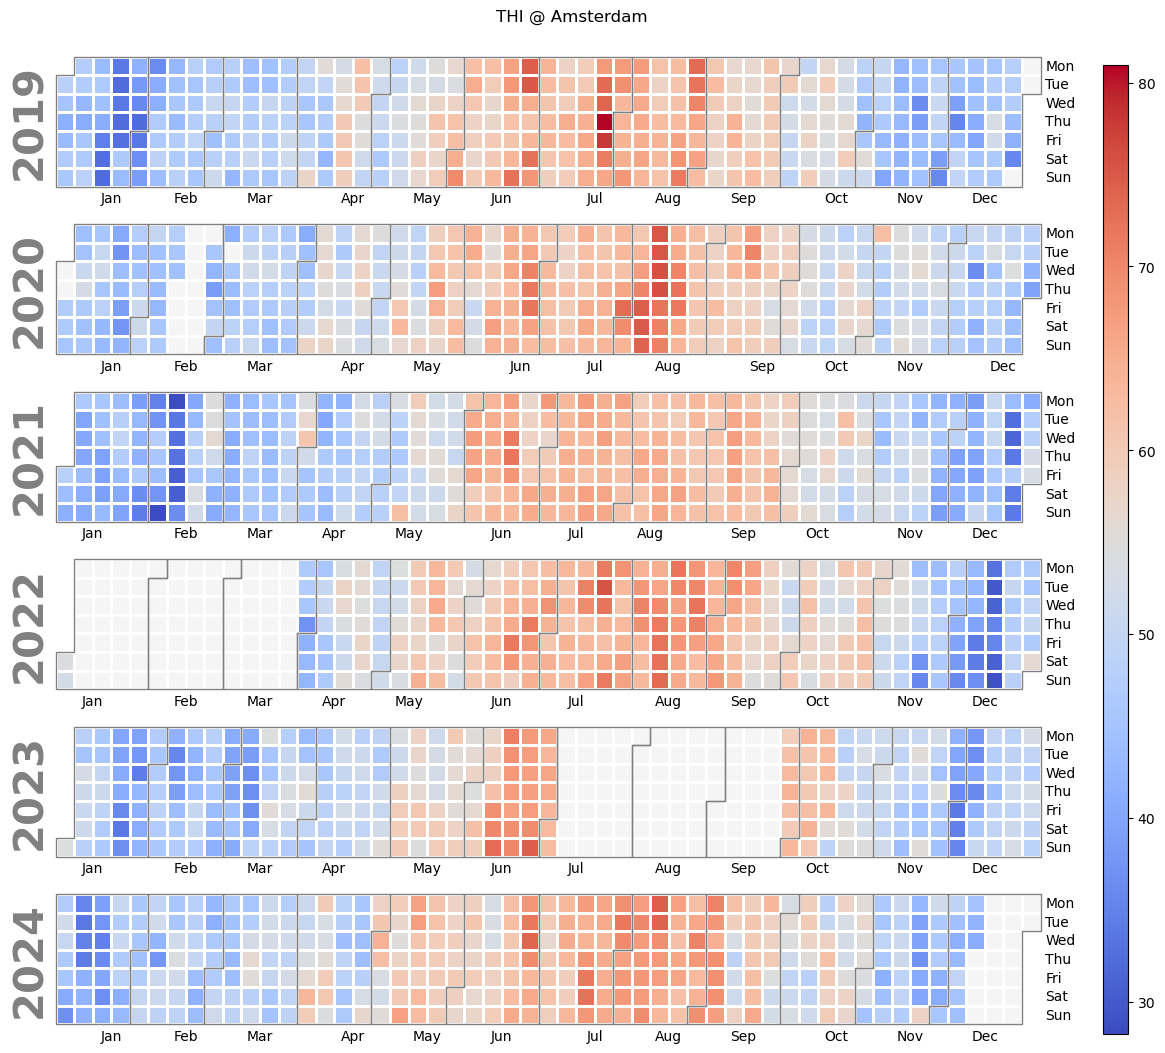

In [22]:
# Plot THI time series calendar heatmap
pdTimeSeries = pd.Series(myTable['THI'].values, index=pd.DatetimeIndex(myTable['Date']))
logging.getLogger('matplotlib.font_manager').disabled = True
cp = calplot.calplot(pdTimeSeries, dropzero=True, cmap='coolwarm', suptitle='THI @ ' + myCity)

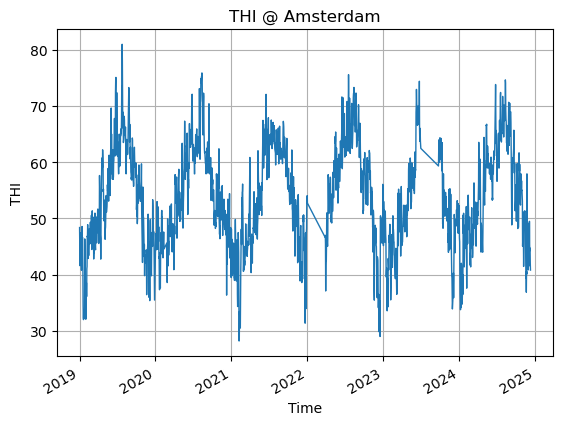

In [23]:
# Plot THI time series dynamics
ts = pdTimeSeries.plot(title='THI @ ' + myCity, ylabel="THI", xlabel="Time", lw=1, grid=True)